In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [15]:
data = pd.read_csv(r"../Data/raw/creditcard.csv")


In [16]:
data.drop(["Time"], axis=1, inplace=True)


In [17]:
# scale the amount column
data["Amount"] = StandardScaler().fit_transform(data["Amount"].values.reshape(-1, 1))


In [18]:
x_train, x_test = train_test_split(data, test_size=0.2, random_state=42)

x_train = x_train[x_train.Class == 0]
x_train = x_train.drop(["Class"], axis=1)

y_test = x_test["Class"]
x_test = x_test.drop(["Class"], axis=1)

x_train = x_train.values
x_test = x_test.values


In [19]:
autoencoder = tf.keras.models.load_model(r"../Models/raw_data-static_model.h5")

In [20]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

1781/1781 [==============================] - 3s 2ms/step


,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.729550,0.001720
std,3.422134,0.041443
min,0.035257,0.000000
25%,0.229663,0.000000
50%,0.375668,0.000000
75%,0.612858,0.000000
max,256.805124,1.000000


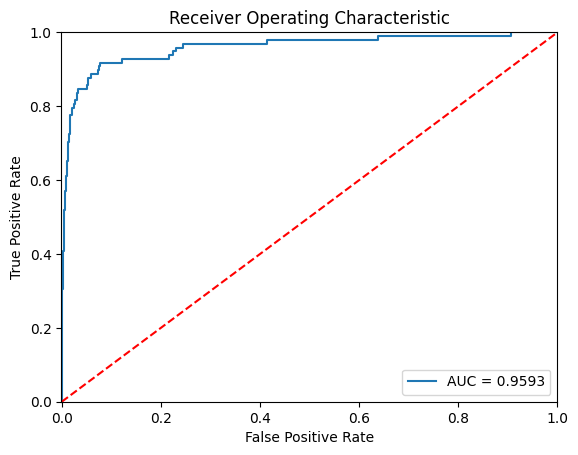

In [21]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

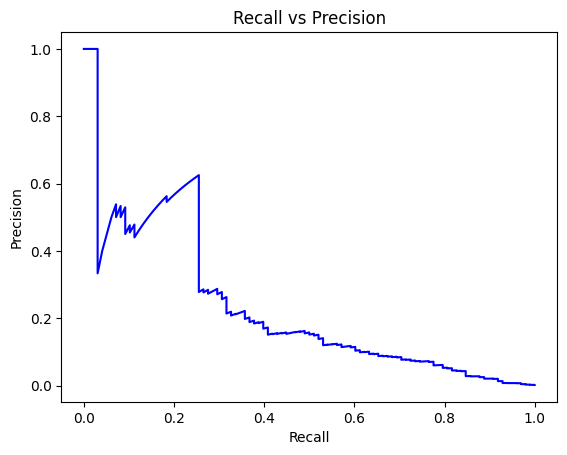

In [22]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

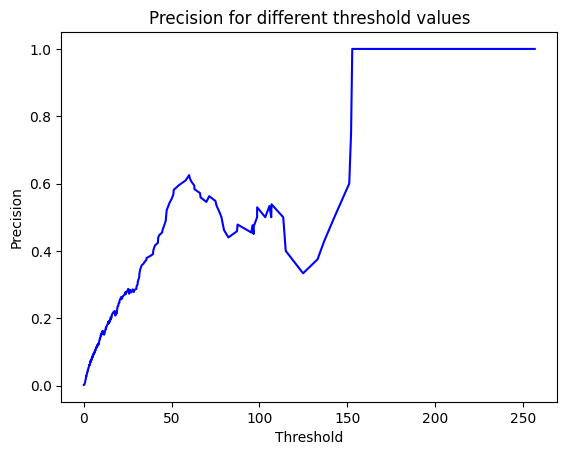

In [23]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

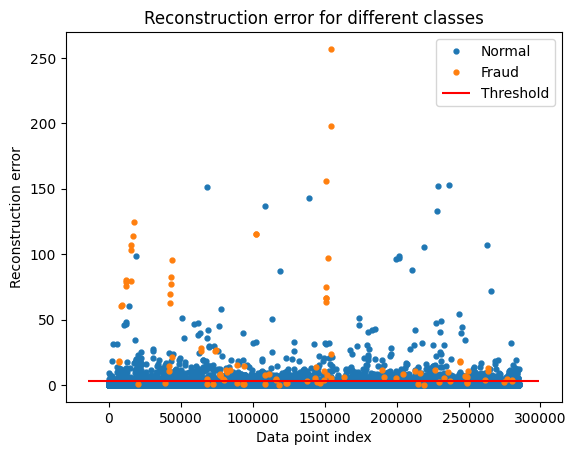

In [24]:
threshold = 2.9

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

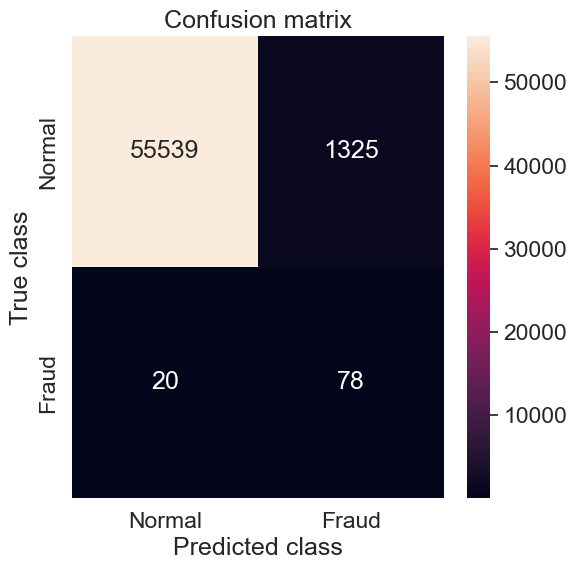

In [32]:
LABELS = ["Normal", "Fraud"]
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()